In [49]:
import numpy as np
import pandas as pd
import cozmo
import cv2
import math
from cozmo.util import degrees, distance_mm, speed_mmps
from PIL import Image
import random
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [50]:
def compare_images(imageA, imageB):
  # See https://en.wikipedia.org/wiki/Mean_squared_error 
  dimensions = imageA.astype("float").shape
  width = dimensions[1]
  height = dimensions[0]
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  # Dividing the values so they fit 
  err /= (width * height * width * height)
  return err

In [ ]:
img = Image.open("Panorama.jpeg")
image = cv2.resize(np.array(img), (320, 320))
compare_images(image, image)
#cv2.imshow("test", image)

In [51]:
# Given a particle (position), get a image from the panorama centered on that position
def slice(pose, imageWidth):
    # initialize boundaries
    pano = Image.open("Panorama.jpeg")
    panoWidth, panoHeight = pano.size
    
    # Get initial bounds, regardless of if they are outside
    leftBound = pose - imageWidth / 2
    rightBound = pose + imageWidth / 2

    #initialize the final image
    sliced_image = None

    #if the left goes out of bounds
    if leftBound < 0:
        # the portion of the image that exceeds the left boundary and wraps to the right
        spillover_width = imageWidth / 2 - pose
        spillover_bounds = (panoWidth - spillover_width, 0, panoWidth, panoHeight)
        spillover_image = pano.crop(spillover_bounds)

        # the portion of the image that doesn't "spill over" across the left boundary
        unspilled_bounds = (0, 0, rightBound, panoHeight)
        unspilled_image = pano.crop(unspilled_bounds)

        #concactinate the two images together with spilled first then unspilled
        sliced_image = Image.new('RGB', (spillover_image.width + unspilled_image.width, panoHeight))
        sliced_image.paste(spillover_image, (0, 0))
        sliced_image.paste(unspilled_image, (spillover_image.width, 0))

        #save the img as a jpeg
        sliced_image.save("Sliced.jpeg")

    #if the right goes out of bounds
    elif rightBound > panoWidth:
        # the portion of the image that doesn't spill over the right boundary
        unspilled_bounds = (leftBound, 0, panoWidth, panoHeight)
        unspilled_image = pano.crop(unspilled_bounds)

        # the portion of the image that exceeds the right boundary and wraps back to the beginning
        spillover_width = imageWidth / 2 - (panoWidth - pose)
        spillover_bounds = (0, 0, spillover_width, panoHeight)
        spillover_image = pano.crop(spillover_bounds)

        #concactinate the two images together with unspilled first then spilled
        sliced_image = Image.new('RGB', (spillover_image.width + unspilled_image.width, panoHeight))
        sliced_image.paste(unspilled_image, (0, 0))
        sliced_image.paste(spillover_image, (unspilled_image.width, 0))

        #save the img as a jpeg
        sliced_image.save("Sliced.jpeg")
        
    else:
        # simple case, no spillover
        bounds = (leftBound, 0, rightBound, panoHeight)
        sliced_image = pano.crop(bounds)
        sliced_image = np.array(sliced_image)

        #save the img as a jpeg
        cv2.imwrite("Sliced.jpeg", sliced_image)

    return sliced_image

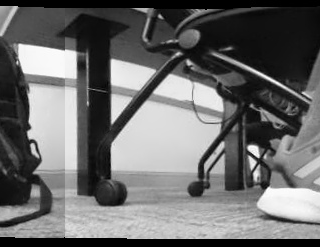

In [78]:
#Test of all three cases of slice, right out of bounds, left out of bounds, and somewhere in middle of pano
slice(1900, 320)
#slice(0, 320)
#slice(500, 320)

In [52]:
sensorVariance = 0.01
proportionalMotionVariance = 0.01

def measurement_model(latestImage, particlePose):
  # Gaussian (i.e. normal) error, see https://en.wikipedia.org/wiki/Normal_distribution
  # same as p_hit in Figure 6.2(a), but without bounds. Table 5.2
  img = Image.open("Panorama.jpeg")
  # get the slice of the panorama that corresponds to the pose passed as a parameter
  particle = slice(particlePose, 320)
  particle = np.array(particle)
  width, height = particle.size
  #resize the images for proper comparison
  cv_particle = cv2.resize(particle, (width, height))
  image2 = cv2.resize(latestImage, (width, height))
  # compare how similar/different they are using MSE
  diff = compare_images(cv_particle, image2)
  #see Text Table 5.2, implementation of probability normal distribution
  return (1.0 / math.sqrt(2 * math.pi * sensorVariance)) * math.exp(- (diff * diff) / (2 * sensorVariance))
def motion_model(movement, current_position, width):
  # making variance proportional to magnitude of motion command
  newX = current_position + movement + sample_normal_distribution(abs(movement * proportionalMotionVariance)) % width
  # apply modulus to make sure the newX wraps around when it passes over either edge of the panorama
  return newX % width
def sample_normal_distribution(variance):
  sum = 0
  for i in range(12):
    sum += (2.0 * random.random()) - 1.0
  return math.sqrt(variance) * sum / 2.0


In [53]:
def localize(robot: cozmo.robot.Robot):
    robot.camera.image_stream_enabled = True

    # load in panorama
    raw_panorama = cv2.imread("Panorama.jpeg")
    # get the width for determining movement
    width = raw_panorama.shape[1]

    # generate a (random) initial population of M possible positions
    M = 150
    particles = [] 
    for i in range(M):
        particles.append(random.randint(0, width))

    poses_and_weights = None

    iterations = 10
    for i in range(iterations):
        robot.turn_in_place(degrees(-10.0)).wait_for_completed()
        latest_image = robot.world.latest_image
        while latest_image is None:
            latest_image = robot.world.latest_image
        annotated = latest_image.annotate_image()
        if latest_image is not None:
            converted = annotated.convert()
            converted.save("latestImage.jpeg", "JPEG", resolution=10)
        current_image = latest_image.annotate_image(scale=None, fit_size=None, resample_mode=0)
        np_curr_image = np.array(current_image)
    
        # Initialize arrays to store poses and corresponding weightws
        poses_and_weights = np.empty([M, 2])

        newPosition = None

        # for each possible position
        for p in range(M):
            currentPosition = particles[p]
            # update our belief about where the given pose represents, given the movement just made
            pixel_dist = width / 36 # assuming all rotation steps are equal
            newPosition = motion_model(pixel_dist, currentPosition, width)
            # Assign a weight to this position based on the image difference
            weight = measurement_model(np_curr_image, newPosition) 
            # weight
            poses_and_weights[p] = [newPosition, weight]

        # normalize the relative likelihoods
        total_weight = 0.0
        for p in range(M):
            total_weight += poses_and_weights[p, 1]

        probabilities = []
        for p in range(M): 
            probabilities.append(poses_and_weights[p, 1] / total_weight)
        
        # make CDF
        sum = 0
        cdf = []
        for p in range(M):
            sum += probabilities[p]
            cdf.append(sum)
        
        cdf[M-1] = 1.0

        # Resampling    
        newParticles = []
        for p in range(M):
            p = random.random()
            index = 0
            while p >= cdf[index]:
                index += 1
            newParticles.append(poses_and_weights[index,0])

        # Specify the new population of positions for the next iteration
        particles = newParticles

        # visualize the robot's beliefs about it's current position
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.hist(np.array(newParticles))
        plt.show()

    # predicted_position = 0
    # max_weight = 0
    # for (pose, weight) in poses_and_weights:
    #     if weight > max_weight:
    #         predicted_position = pose
    #         max_weight = weight

    
    poses = poses_and_weights[:,0]
    kde = gaussian_kde(poses)
    samples = np.linspace(min(poses), max(poses), 10)
    probs = kde.evaluate(samples)
    maxima_index = probs.argmax()
    maxima = samples[maxima_index]
    slice(maxima, 320)

    # for testing purposes: can compare to latestImage.jpeg to see if the predicted position matches
    # the actual position of the robot.
    #slice(predicted_position, 320)


/home/bendurham441/.local/lib/python3.8/site-packages/cozmo/event.py:488: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  return await asyncio.wait_for(f, timeout, loop=self._loop)
2023-04-23 15:45:55,957 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-23 15:45:55,957 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-23 15:45:55,957 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-23 15:45:55,957 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-23 15:45:55,957 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=0

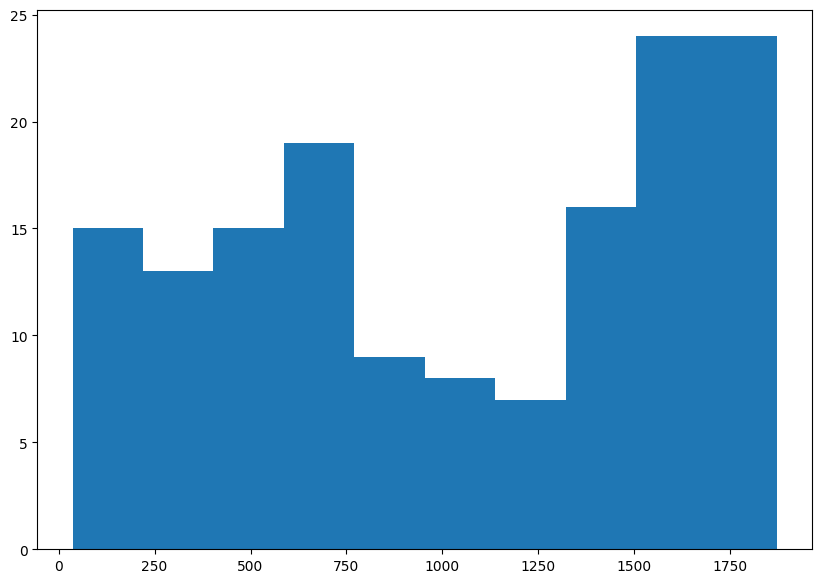

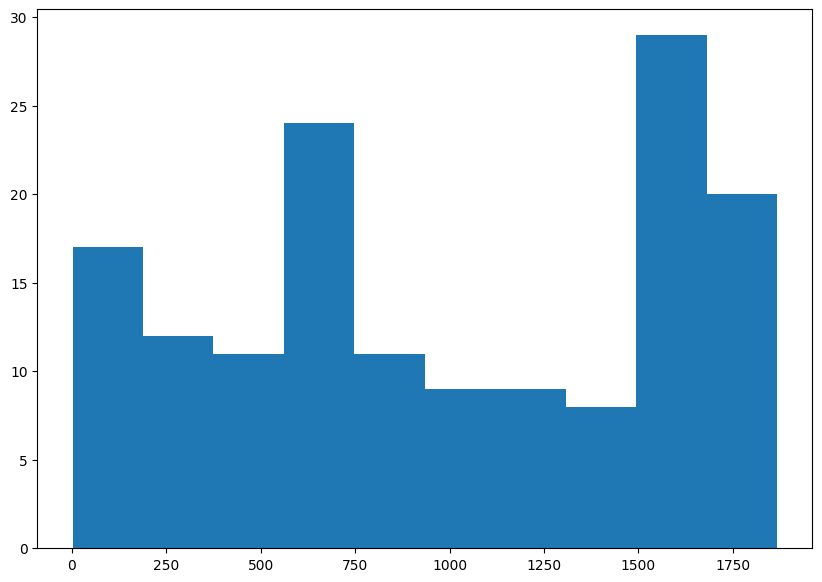

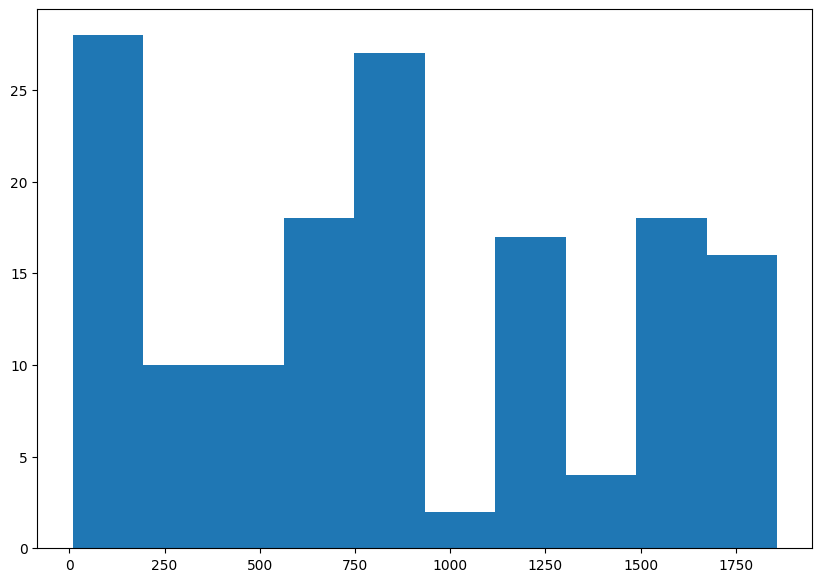

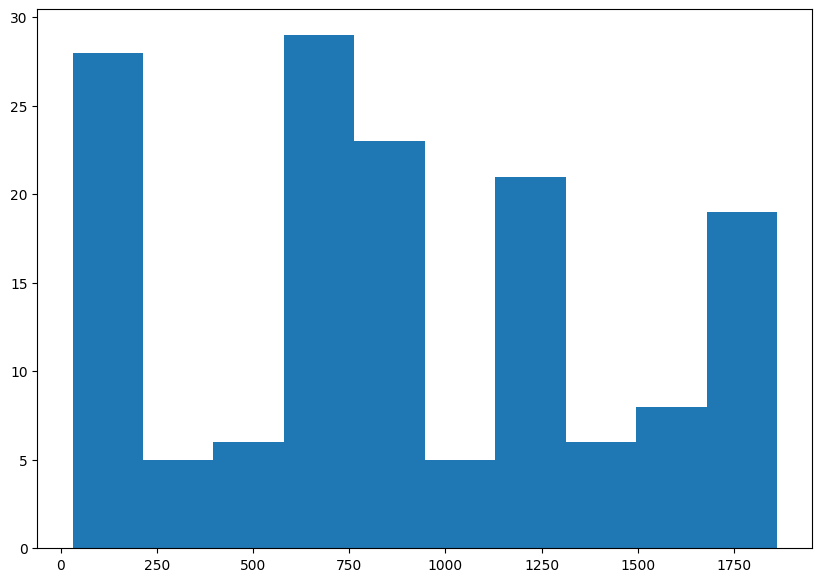

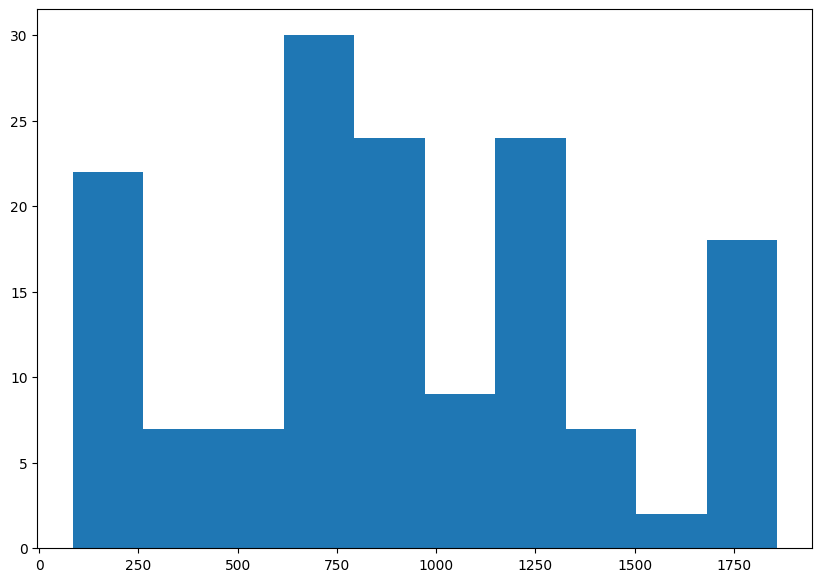

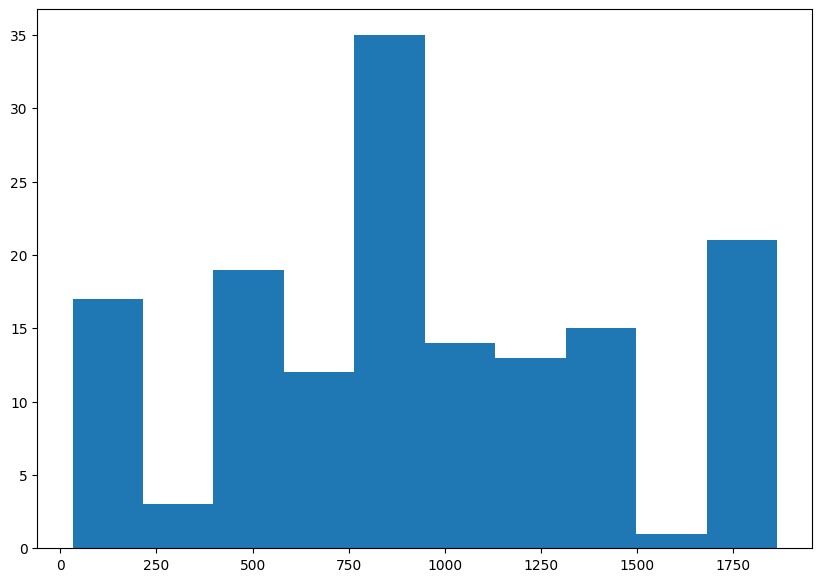

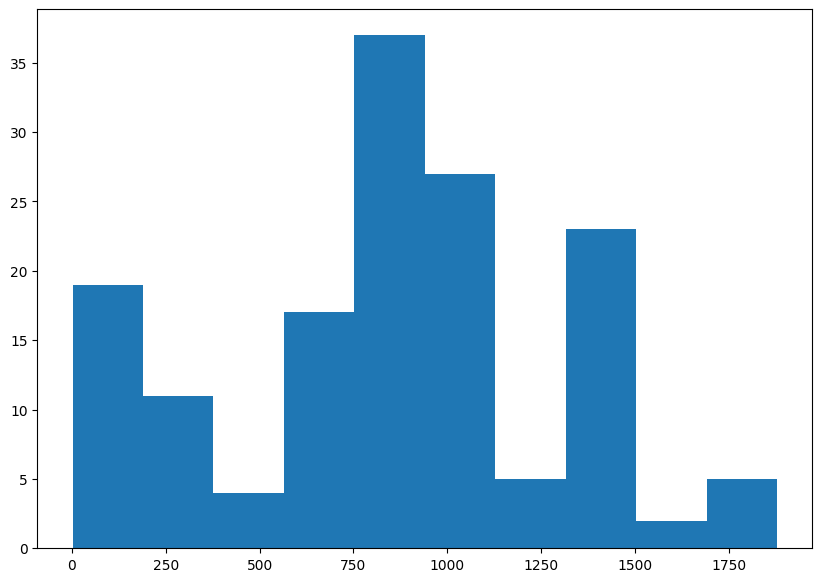

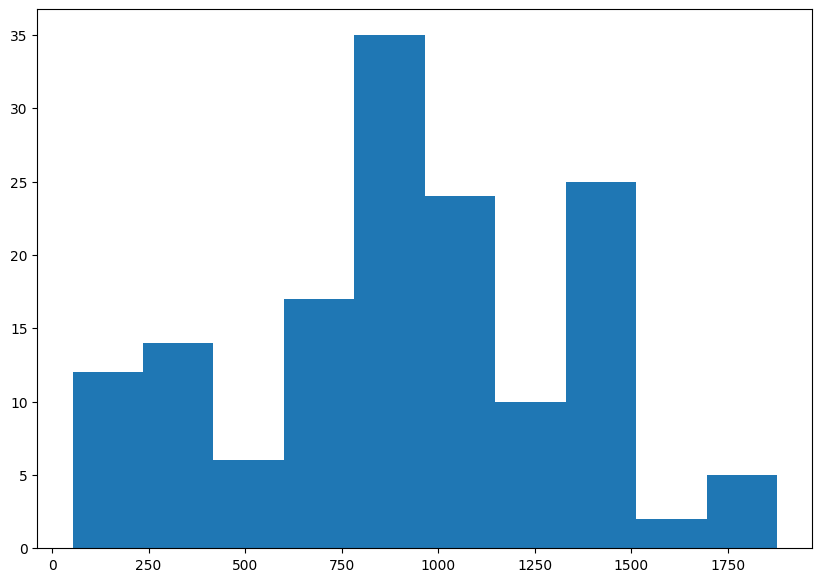

/home/bendurham441/.local/lib/python3.8/site-packages/cozmo/annotate.py:127: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(self.text, font=self.font)
/home/bendurham441/.local/lib/python3.8/site-packages/cozmo/annotate.py:127: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(self.text, font=self.font)


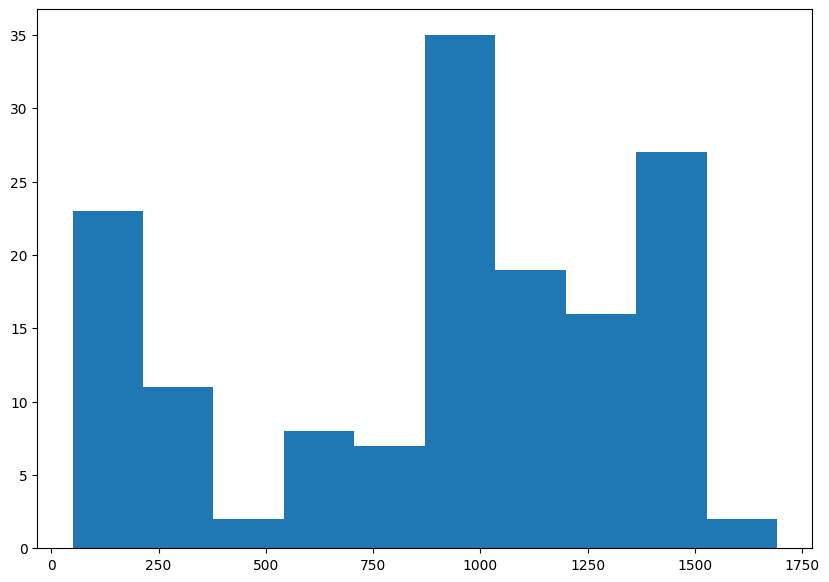

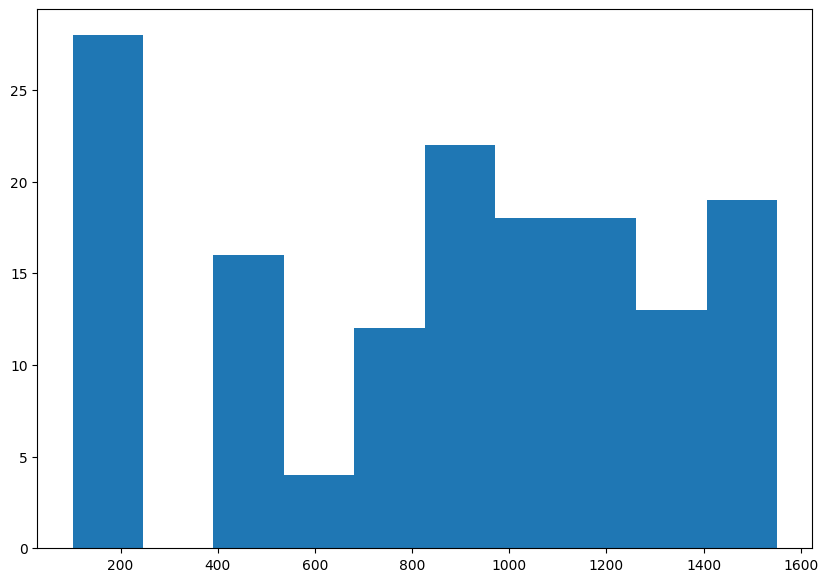

2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down connection
2023-04-23 15:46:47,647 cozmo.general INFO     Shutting down con

In [54]:
cozmo.run_program(localize)

In [48]:
slice(500, 320)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[231, 231, 231],
        [231, 231, 231],
        [231, 231, 231],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [107, 107, 107],
        [107, 107, 107],
        [104, 104, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [103, 103, 103],
        [101, 101, 101],
        [100, 100, 100]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [101, 101, 101],
        [ 97,  97,  97],
        [ 98,  98,  98]]

In [80]:
home = cv2.imread("latestImage.jpeg")
pano = cv2.imread("Panorama.jpeg")
width, height = home.shape[:2]
home_array = np.array(home)
pano_width = pano.shape[1]
for i in range(0, 360, 5):
    x_displ = i * width/360
    partial_pano = np.array(slice(x_displ, width))
    partial_pano_resize = cv2.resize(partial_pano, (height, width))
    cv2.imwrite("test1.jpeg", partial_pano_resize)
    cv2.imwrite("test2.jpeg", home)
    print("test")
    print(compare_images(home_array, partial_pano_resize))

test
0.08609875844319662
test
0.08558096110026042
test
0.08487597045898437
test
0.08434573160807292
test
0.08388957214355469
test
0.0832992167154948
test
0.08287321980794271
test
0.08249612477620442
test
0.0819831782023112
test
0.08164535675048828
test
0.08131658528645834
test
0.08091012115478516
test
0.08068290354410808
test
0.0806297119140625
test
0.08062523040771484
test
0.08053995259602864
test
0.0805171869913737
test
0.08048733622233073
test
0.08067113545735677
test
0.08107373657226563
test
0.08157560017903646
test
0.08194341786702473
test
0.08227709197998047
test
0.08268902231852214
test
0.08296245880126953
test
0.08314666798909505
test
0.08330144805908203
test
0.08338949127197266
test
0.0834208267211914
test
0.08353551534016927
test
0.08362636159261068
test
0.08379541015625
test
0.08389035237630209
test
0.08387461140950521
test
0.08387343139648437
test
0.08406369984944662
test
0.0843478032430013
test
0.0844276860555013
test
0.0845626205444336
test
0.08472664794921875
test
0.0848